In [4]:
#toy experiments for leaky ReLU
from argparse import ArgumentParser
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
import random

In [6]:
lr = 1e-4
n_epochs = 25
batch_size = 32
noise_dim = 32
img_dim = 28 * 28 * 1
hidden_size = 256

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [8]:
class Generator(nn.Module):
    def __init__(self, activation):
        super(Generator, self).__init__()
        layers = [
            nn.Linear(noise_dim, hidden_size),
            nn.LeakyReLU(0.02),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.02),
            nn.Linear(hidden_size, img_dim),
        ]

        if activation == 'tanh':
            layers.append(nn.Tanh())
        elif activation == 'sigmoid':
            layers.append(nn.Sigmoid())
        elif activation == 'gelu':
            layers.append(nn.GELU())
        
        self.model = nn.Sequential(*layers)

    def forward(self, z):
        return self.model(z)

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim, hidden_size),
            nn.LeakyReLU(0.02),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.02),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        return self.model(flattened)

In [15]:
def train_gan(leak, n_epochs, train_loader): 
    generator = Generator(leak).to(device)
    discriminator = Discriminator(leak).to(device)

    optim_g = optim.Adam(generator.parameters(), lr=lr)
    optim_d = optim.Adam(discriminator.parameters(), lr=lr)

    criterion = nn.BCELoss()
    optim_d = optim.Adam(discriminator.parameters(), lr=2e-4)
    optim_g = optim.Adam(generator.parameters(), lr=2e-4)
    d_losses, g_losses = [], []
    for epoch in range(n_epochs):
        for i, (real_images, _) in enumerate(train_loader):
            current_batch_size = real_images.size(0)

            real_labels = torch.ones(current_batch_size, 1).to(device)
            fake_labels = torch.zeros(current_batch_size, 1).to(device)

            real_images = real_images.to(device)
            real_images = real_images.view(current_batch_size, -1)

            optim_d.zero_grad()

            outputs = discriminator(real_images)
            d_loss_real = criterion(outputs, real_labels)
            d_loss_real.backward()

            z = torch.randn(current_batch_size, noise_dim).to(device)
            fake_images = generator(z)
            outputs = discriminator(fake_images.detach())  
            d_loss_fake = criterion(outputs, fake_labels)
            d_loss_fake.backward()

            d_loss = d_loss_real + d_loss_fake
            optim_d.step()

            optim_g.zero_grad()

            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()

            optim_g.step()
            d_loss = d_loss_real + d_loss_fake
            d_losses.append(d_loss.item())

            g_loss = criterion(outputs, real_labels)
            g_losses.append(g_loss.item())

            if (i + 1) % 200 == 0:
                print(f'Epoch [{epoch + 1}/{n_epochs}], Step [{i + 1}/{len(train_loader)}], '
                    f'D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

    print('Training finished.')

    plt.figure(figsize=(10, 5))
    plt.title("g & d loss during training")
    plt.plot(g_losses, label="g loss")
    plt.plot(d_losses, label="d loss")
    plt.xlabel("itrs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    return d_losses, g_losses

In [16]:
leak_val = [0, 0.01, 0.02, 0.03]

Training leakiness: 0
Epoch [1/25], Step [200/1875], D Loss: 0.0717, G Loss: 3.3054
Epoch [1/25], Step [400/1875], D Loss: 0.0443, G Loss: 4.5762
Epoch [1/25], Step [600/1875], D Loss: 0.0305, G Loss: 5.0904
Epoch [1/25], Step [800/1875], D Loss: 0.0316, G Loss: 4.8721
Epoch [1/25], Step [1000/1875], D Loss: 0.0193, G Loss: 4.2754
Epoch [1/25], Step [1200/1875], D Loss: 0.0089, G Loss: 5.9715
Epoch [1/25], Step [1400/1875], D Loss: 0.1280, G Loss: 4.9549
Epoch [1/25], Step [1600/1875], D Loss: 0.0205, G Loss: 4.9350
Epoch [1/25], Step [1800/1875], D Loss: 0.0050, G Loss: 7.2975
Epoch [2/25], Step [200/1875], D Loss: 0.1522, G Loss: 3.5409
Epoch [2/25], Step [400/1875], D Loss: 0.0552, G Loss: 4.7686
Epoch [2/25], Step [600/1875], D Loss: 0.0101, G Loss: 8.2101
Epoch [2/25], Step [800/1875], D Loss: 0.0054, G Loss: 8.1377
Epoch [2/25], Step [1000/1875], D Loss: 0.0899, G Loss: 4.8252
Epoch [2/25], Step [1200/1875], D Loss: 1.2227, G Loss: 2.8299
Epoch [2/25], Step [1400/1875], D Loss: 0

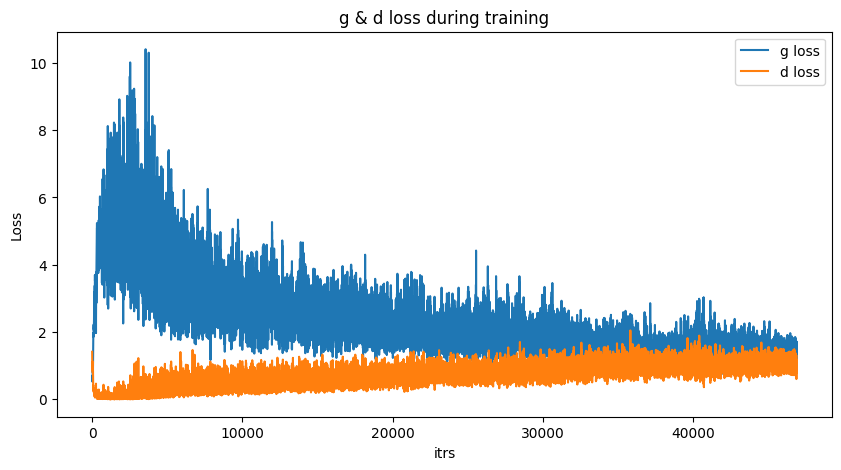

Training leakiness: 0.01
Epoch [1/25], Step [200/1875], D Loss: 0.4618, G Loss: 1.9223
Epoch [1/25], Step [400/1875], D Loss: 0.0984, G Loss: 4.0413
Epoch [1/25], Step [600/1875], D Loss: 0.0439, G Loss: 4.9772
Epoch [1/25], Step [800/1875], D Loss: 0.0224, G Loss: 5.2217
Epoch [1/25], Step [1000/1875], D Loss: 0.0226, G Loss: 4.5738
Epoch [1/25], Step [1200/1875], D Loss: 0.0216, G Loss: 5.4601
Epoch [1/25], Step [1400/1875], D Loss: 0.1093, G Loss: 5.6374
Epoch [1/25], Step [1600/1875], D Loss: 0.0658, G Loss: 4.7699
Epoch [1/25], Step [1800/1875], D Loss: 0.0231, G Loss: 6.0406
Epoch [2/25], Step [200/1875], D Loss: 0.2967, G Loss: 5.7309
Epoch [2/25], Step [400/1875], D Loss: 0.2063, G Loss: 5.0770
Epoch [2/25], Step [600/1875], D Loss: 0.0953, G Loss: 4.3864
Epoch [2/25], Step [800/1875], D Loss: 0.1478, G Loss: 3.9371
Epoch [2/25], Step [1000/1875], D Loss: 0.1526, G Loss: 4.2949
Epoch [2/25], Step [1200/1875], D Loss: 0.1015, G Loss: 3.2784
Epoch [2/25], Step [1400/1875], D Loss

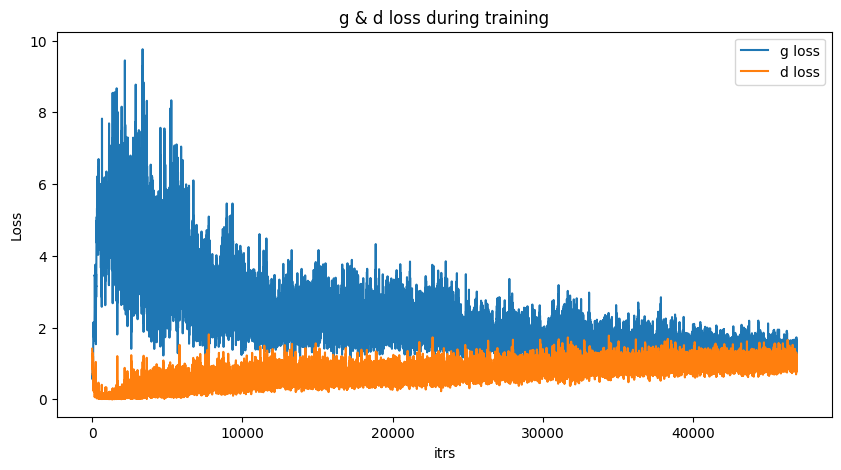

Training leakiness: 0.02
Epoch [1/25], Step [200/1875], D Loss: 0.1113, G Loss: 3.7102
Epoch [1/25], Step [400/1875], D Loss: 0.0608, G Loss: 4.4070
Epoch [1/25], Step [600/1875], D Loss: 0.0621, G Loss: 4.5176
Epoch [1/25], Step [800/1875], D Loss: 0.1002, G Loss: 4.2993
Epoch [1/25], Step [1000/1875], D Loss: 0.0513, G Loss: 4.2660
Epoch [1/25], Step [1200/1875], D Loss: 0.0969, G Loss: 4.3942
Epoch [1/25], Step [1400/1875], D Loss: 0.1124, G Loss: 5.1406
Epoch [1/25], Step [1600/1875], D Loss: 0.0464, G Loss: 5.9473
Epoch [1/25], Step [1800/1875], D Loss: 0.0229, G Loss: 4.5578
Epoch [2/25], Step [200/1875], D Loss: 0.0350, G Loss: 6.3698
Epoch [2/25], Step [400/1875], D Loss: 0.1036, G Loss: 4.1387
Epoch [2/25], Step [600/1875], D Loss: 0.0226, G Loss: 7.3940
Epoch [2/25], Step [800/1875], D Loss: 0.0818, G Loss: 5.4711
Epoch [2/25], Step [1000/1875], D Loss: 0.0281, G Loss: 6.3916
Epoch [2/25], Step [1200/1875], D Loss: 0.1300, G Loss: 2.9523
Epoch [2/25], Step [1400/1875], D Loss

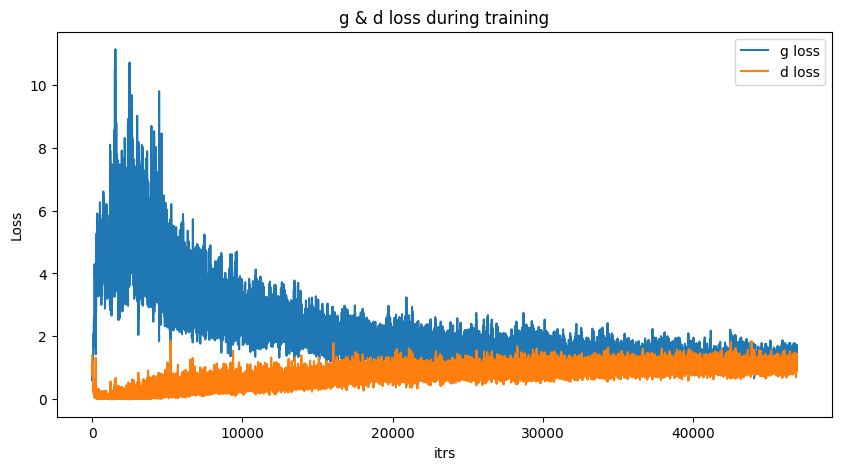

Training leakiness: 0.03
Epoch [1/25], Step [200/1875], D Loss: 0.1824, G Loss: 2.9664
Epoch [1/25], Step [400/1875], D Loss: 0.0593, G Loss: 5.0114
Epoch [1/25], Step [600/1875], D Loss: 0.0688, G Loss: 4.4036
Epoch [1/25], Step [800/1875], D Loss: 0.0397, G Loss: 5.3689
Epoch [1/25], Step [1000/1875], D Loss: 0.0490, G Loss: 5.5558
Epoch [1/25], Step [1200/1875], D Loss: 0.0266, G Loss: 4.9043
Epoch [1/25], Step [1400/1875], D Loss: 0.5734, G Loss: 5.0359
Epoch [1/25], Step [1600/1875], D Loss: 0.1068, G Loss: 5.1755
Epoch [1/25], Step [1800/1875], D Loss: 0.0411, G Loss: 5.1362
Epoch [2/25], Step [200/1875], D Loss: 0.1130, G Loss: 4.0605
Epoch [2/25], Step [400/1875], D Loss: 0.0731, G Loss: 4.3503
Epoch [2/25], Step [600/1875], D Loss: 0.0791, G Loss: 4.1277
Epoch [2/25], Step [800/1875], D Loss: 0.0234, G Loss: 5.2792
Epoch [2/25], Step [1000/1875], D Loss: 0.1157, G Loss: 4.5197
Epoch [2/25], Step [1200/1875], D Loss: 0.0938, G Loss: 5.1556
Epoch [2/25], Step [1400/1875], D Loss

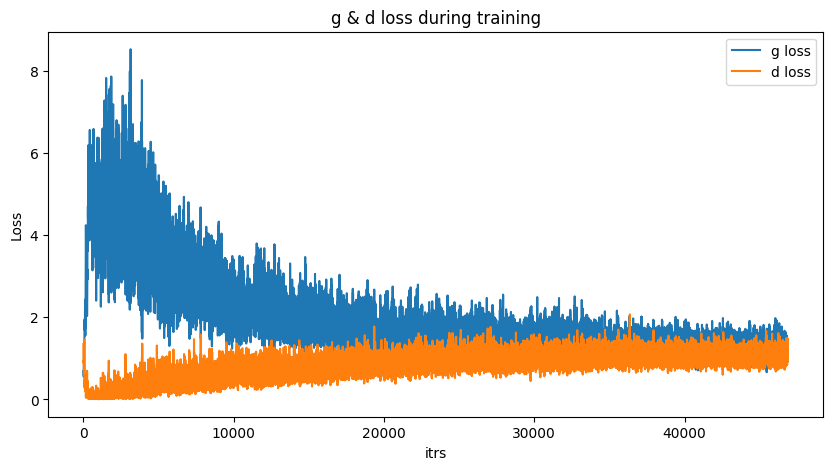

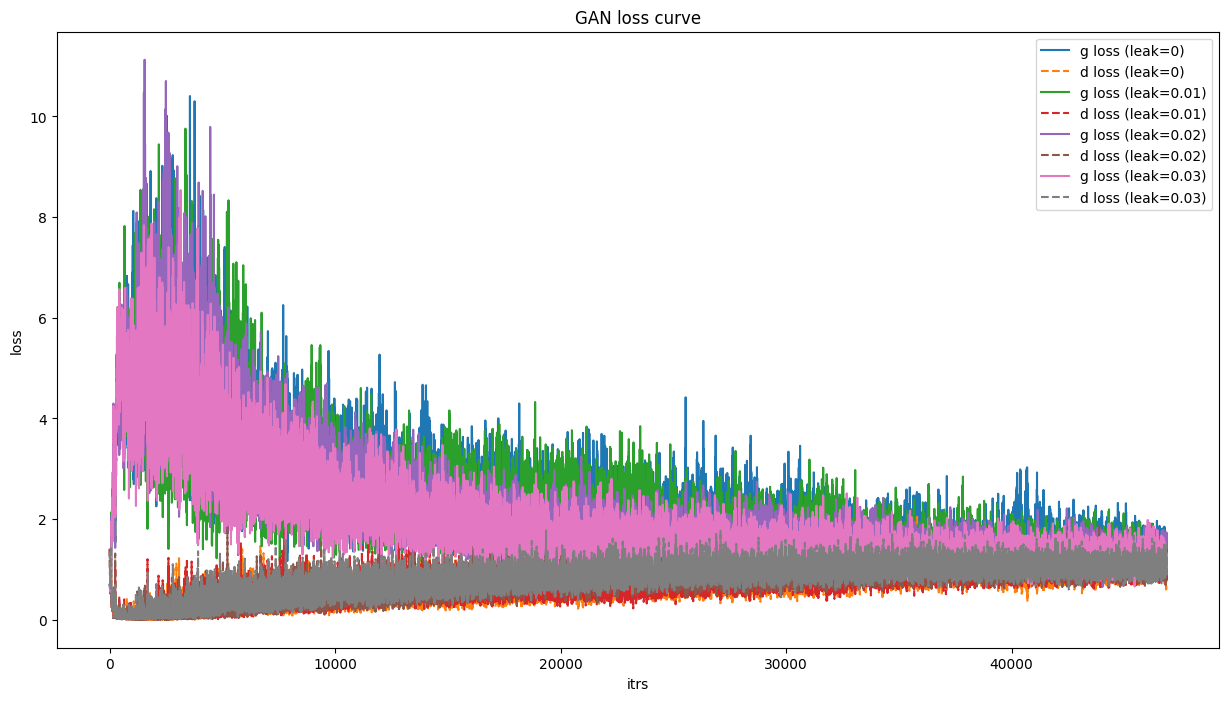

In [17]:
all_d_losses = {}
all_g_losses = {}

for leak in leak_val:
    print(f"Training leakiness: {leak}")
    d_losses, g_losses = train_gan(leak, n_epochs, train_loader)
    all_d_losses[leak] = d_losses
    all_g_losses[leak] = g_losses

plt.figure(figsize=(15, 8))

for leak in leak_val:
    plt.plot(all_g_losses[leak], label=f"g loss (leak={leak})")
    plt.plot(all_d_losses[leak], label=f"d loss (leak={leak})", linestyle='--')

plt.title("GAN loss curve")
plt.xlabel("itrs")
plt.ylabel("loss")
plt.legend()
plt.show()

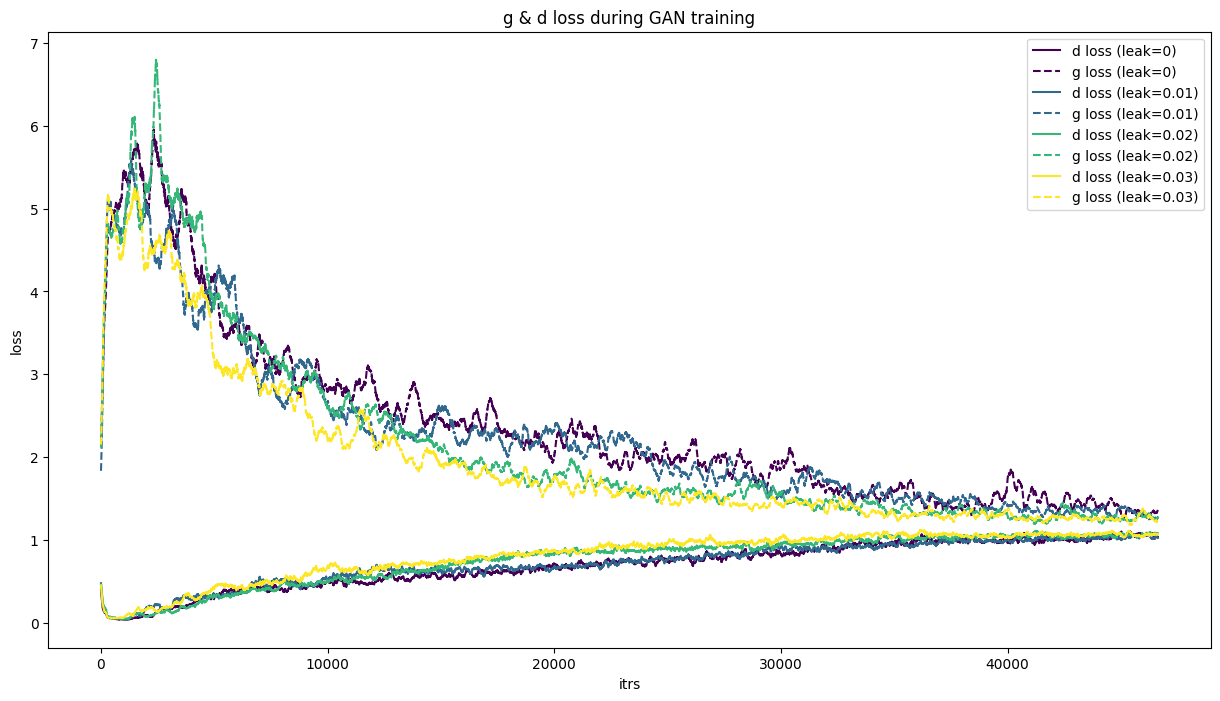

In [19]:
window_size = 250 

def moving_average(data, window_size):
    cumsum = np.cumsum(np.insert(data, 0, 0)) 
    return (cumsum[window_size:] - cumsum[:-window_size]) / float(window_size)

plt.figure(figsize=(15, 8))

colors = plt.cm.viridis(np.linspace(0, 1, len(leak_val)))

for idx, leak in enumerate(leak_val):
    d_losses = all_d_losses[leak]
    g_losses = all_g_losses[leak]
    d_losses_moving_avg = moving_average(d_losses, window_size)
    g_losses_moving_avg = moving_average(g_losses, window_size)

    plt.plot(d_losses_moving_avg, label=f"d loss (leak={leak})", color=colors[idx])
    plt.plot(g_losses_moving_avg, label=f"g loss (leak={leak})", linestyle='--', color=colors[idx])

plt.title("g & d loss during GAN training")
plt.xlabel("itrs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [10]:
def train_gan_activation(activation, n_epochs, train_loader): 
    generator = Generator(activation).to(device)
    discriminator = Discriminator().to(device)

    optim_g = optim.Adam(generator.parameters(), lr=lr)
    optim_d = optim.Adam(discriminator.parameters(), lr=lr)

    criterion = nn.BCELoss()
    optim_d = optim.Adam(discriminator.parameters(), lr=2e-4)
    optim_g = optim.Adam(generator.parameters(), lr=2e-4)
    d_losses, g_losses = [], []
    for epoch in range(n_epochs):
        for i, (real_images, _) in enumerate(train_loader):
            current_batch_size = real_images.size(0)

            real_labels = torch.ones(current_batch_size, 1).to(device)
            fake_labels = torch.zeros(current_batch_size, 1).to(device)

            real_images = real_images.to(device)
            real_images = real_images.view(current_batch_size, -1)

            optim_d.zero_grad()

            outputs = discriminator(real_images)
            d_loss_real = criterion(outputs, real_labels)
            d_loss_real.backward()

            z = torch.randn(current_batch_size, noise_dim).to(device)
            fake_images = generator(z)
            outputs = discriminator(fake_images.detach())  
            d_loss_fake = criterion(outputs, fake_labels)
            d_loss_fake.backward()

            d_loss = d_loss_real + d_loss_fake
            optim_d.step()

            optim_g.zero_grad()

            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()

            optim_g.step()
            d_loss = d_loss_real + d_loss_fake
            d_losses.append(d_loss.item())

            g_loss = criterion(outputs, real_labels)
            g_losses.append(g_loss.item())

            if (i + 1) % 200 == 0:
                print(f'Epoch [{epoch + 1}/{n_epochs}], Step [{i + 1}/{len(train_loader)}], '
                    f'D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

    print('Training finished.')

    plt.figure(figsize=(10, 5))
    plt.title("g & d loss during training")
    plt.plot(g_losses, label="g loss")
    plt.plot(d_losses, label="d loss")
    plt.xlabel("itrs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    return d_losses, g_losses

Training with activation function: softsign
Epoch [1/25], Step [200/1875], D Loss: 0.1744, G Loss: 2.7108
Epoch [1/25], Step [400/1875], D Loss: 0.0732, G Loss: 5.7518
Epoch [1/25], Step [600/1875], D Loss: 0.0479, G Loss: 4.2273
Epoch [1/25], Step [800/1875], D Loss: 0.0473, G Loss: 4.9677
Epoch [1/25], Step [1000/1875], D Loss: 0.0594, G Loss: 4.2775
Epoch [1/25], Step [1200/1875], D Loss: 0.0394, G Loss: 4.3175
Epoch [1/25], Step [1400/1875], D Loss: 0.1048, G Loss: 5.6836
Epoch [1/25], Step [1600/1875], D Loss: 0.1204, G Loss: 5.3747
Epoch [1/25], Step [1800/1875], D Loss: 0.0844, G Loss: 8.2337
Epoch [2/25], Step [200/1875], D Loss: 0.4877, G Loss: 6.9381
Epoch [2/25], Step [400/1875], D Loss: 0.3534, G Loss: 4.3441
Epoch [2/25], Step [600/1875], D Loss: 0.1580, G Loss: 5.1349
Epoch [2/25], Step [800/1875], D Loss: 0.0946, G Loss: 4.5561
Epoch [2/25], Step [1000/1875], D Loss: 0.0483, G Loss: 3.9508
Epoch [2/25], Step [1200/1875], D Loss: 0.1877, G Loss: 3.5461
Epoch [2/25], Step 

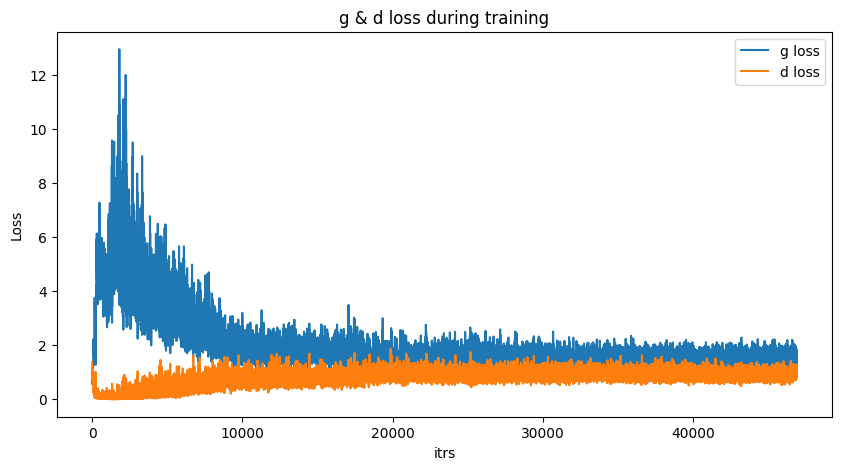

Training with activation function: tanh
Epoch [1/25], Step [200/1875], D Loss: 0.6036, G Loss: 2.0886
Epoch [1/25], Step [400/1875], D Loss: 0.0622, G Loss: 3.9952
Epoch [1/25], Step [600/1875], D Loss: 0.0336, G Loss: 5.0495
Epoch [1/25], Step [800/1875], D Loss: 0.0218, G Loss: 5.7735
Epoch [1/25], Step [1000/1875], D Loss: 0.0306, G Loss: 5.5363
Epoch [1/25], Step [1200/1875], D Loss: 0.0124, G Loss: 6.5598
Epoch [1/25], Step [1400/1875], D Loss: 0.0767, G Loss: 3.8361
Epoch [1/25], Step [1600/1875], D Loss: 0.2942, G Loss: 4.8975
Epoch [1/25], Step [1800/1875], D Loss: 0.0854, G Loss: 5.0084
Epoch [2/25], Step [200/1875], D Loss: 0.0683, G Loss: 5.0971
Epoch [2/25], Step [400/1875], D Loss: 0.1966, G Loss: 5.9258
Epoch [2/25], Step [600/1875], D Loss: 0.7247, G Loss: 2.2416
Epoch [2/25], Step [800/1875], D Loss: 0.1735, G Loss: 4.7382
Epoch [2/25], Step [1000/1875], D Loss: 0.3051, G Loss: 4.4748
Epoch [2/25], Step [1200/1875], D Loss: 0.1895, G Loss: 2.4981
Epoch [2/25], Step [140

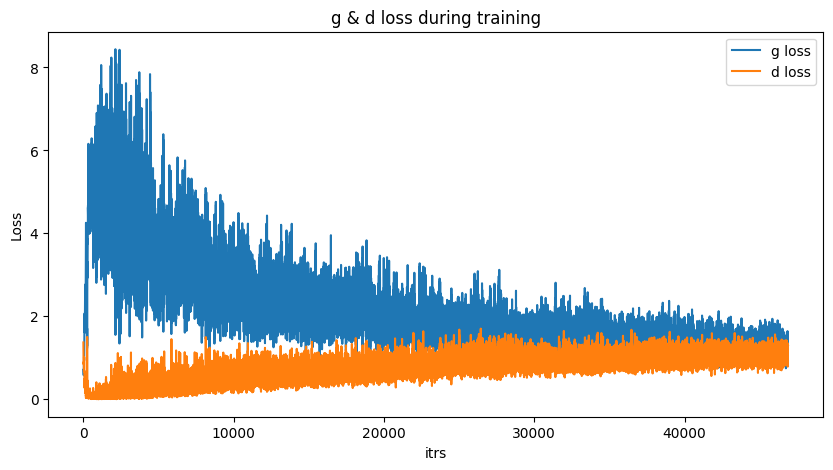

NameError: name 'window_size' is not defined

<Figure size 1500x800 with 0 Axes>

In [13]:
activation_funcs = ['softsign', 'tanh']
all_d_losses = {}
all_g_losses = {}

for func in activation_funcs:
    print(f"Training with activation function: {func}")
    d_losses, g_losses = train_gan_activation(func, n_epochs, train_loader)
    all_d_losses[func] = d_losses
    all_g_losses[func] = g_losses

plt.figure(figsize=(15, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(activation_funcs)))

def moving_average(data, window_size):
    cumsum = np.cumsum(np.insert(data, 0, 0)) 
    return (cumsum[window_size:] - cumsum[:-window_size]) / float(window_size)

for idx, func in enumerate(activation_funcs):    
    d_losses_moving_avg = moving_average(all_d_losses[func], window_size)
    g_losses_moving_avg = moving_average(all_g_losses[func], window_size)

    plt.plot(d_losses_moving_avg, label=f"d loss ({func})", color=colors[idx])
    plt.plot(g_losses_moving_avg, label=f"g loss ({func})", color=colors[idx])

plt.title("GAN loss curve")
plt.xlabel("itrs")
plt.ylabel("loss")
plt.legend()
plt.show()

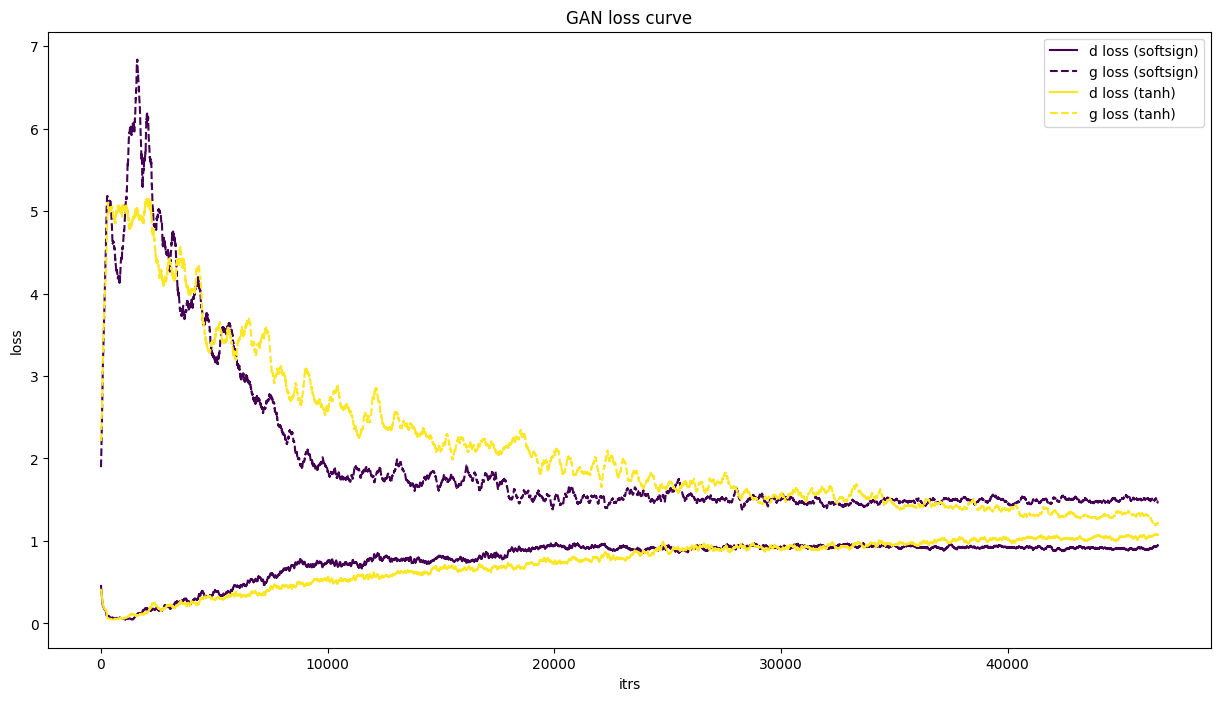

In [18]:
window_size = 250

plt.figure(figsize=(15, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(activation_funcs)))

def moving_average(data, window_size):
    cumsum = np.cumsum(np.insert(data, 0, 0)) 
    return (cumsum[window_size:] - cumsum[:-window_size]) / float(window_size)

for idx, func in enumerate(activation_funcs):    
    d_losses_moving_avg = moving_average(all_d_losses[func], window_size)
    g_losses_moving_avg = moving_average(all_g_losses[func],  window_size)

    plt.plot(d_losses_moving_avg, label=f"d loss ({func})", color=colors[idx])
    plt.plot(g_losses_moving_avg, label=f"g loss ({func})", linestyle = '--', color=colors[idx])

plt.title("GAN loss curve")
plt.xlabel("itrs")
plt.ylabel("loss")
plt.legend()
plt.show()